### API firebase implementation

In [1]:
%pip install firebase-admin 


[notice] A new release of pip available: 22.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### Database connection

In [2]:
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

cred = credentials.Certificate('key.json')  
firebase_admin.initialize_app(cred)

db = firestore.client()

### What is the distribution of clicked advertisements and which are the most clicked

In [3]:
coleccion_advertisements = db.collection('advertisementAnalytics')

docs = coleccion_advertisements.stream()

documentos_existentes = False

for doc in docs:
    documentos_existentes = True
    print(f'ID del documento: {doc.id}')
    print('Datos:', doc.to_dict())
    print('---')

# Mensaje si la colección está vacía
if not documentos_existentes:
    print('La colección "advertisements" está vacía o no existe.')

ID del documento: advertisement_1
Datos: {'endDate': '20241231', 'image': 'https://firebasestorage.googleapis.com/v0/b/senecard-aafad.appspot.com/o/stores_images%2Fc0c18705-2875-4cbe-8369-890dd7ffda08.jpg?alt=media&token=e057314b-7675-47e2-b02f-826cad7a1df0', 'timesTouched': 8, 'description': 'Advertisement Description', 'storeId': 'QuQWLpCIpc7b3AMm33CX', 'available': True, 'title': 'Advertisement Title', 'startDate': '20240101'}
---
ID del documento: advertisement_10
Datos: {'endDate': '20241231', 'image': 'https://firebasestorage.googleapis.com/v0/b/senecard-aafad.appspot.com/o/stores_images%2Fc0c18705-2875-4cbe-8369-890dd7ffda08.jpg?alt=media&token=e057314b-7675-47e2-b02f-826cad7a1df0', 'timesTouched': 19, 'description': 'Advertisement Description', 'storeId': 'QuQWLpCIpc7b3AMm33CX', 'available': True, 'title': 'Advertisement Title', 'startDate': '20240101'}
---
ID del documento: advertisement_100
Datos: {'endDate': '20241231', 'image': 'https://firebasestorage.googleapis.com/v0/b/s

In [4]:
nombre_coleccion = 'advertisementAnalytics'
coleccion = db.collection(nombre_coleccion)


In [5]:
import pandas as pd
docs = coleccion.stream()

datos = []

for doc in docs:
    data = doc.to_dict()
    datos.append({
        'ID': doc.id,
        'timesTouched': data.get('timesTouched', 0)
    })

df = pd.DataFrame(datos)

df

,ID,timesTouched
0,advertisement_1,8
1,advertisement_10,19
2,advertisement_100,6
3,advertisement_11,19
4,advertisement_12,13
...,...,...
95,advertisement_95,13
96,advertisement_96,6
97,advertisement_97,13
98,advertisement_98,15


In [6]:
df_sorted = df.sort_values(by='timesTouched', ascending=False)

df_sorted['cumulative_percentage'] = df_sorted['timesTouched'].cumsum() / df_sorted['timesTouched'].sum() * 100

pareto_threshold = 80
df_sorted['Pareto'] = df_sorted['cumulative_percentage'] <= pareto_threshold


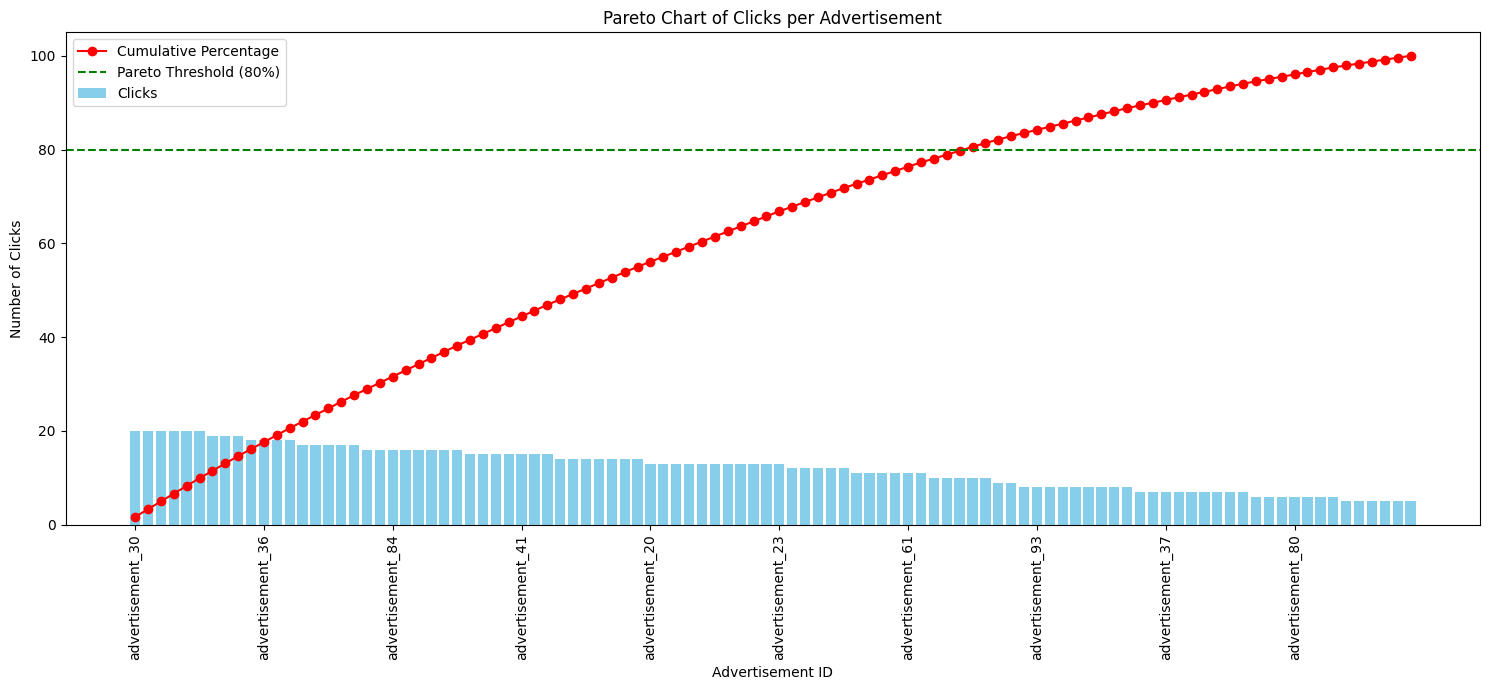

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))  

plt.bar(df_sorted['ID'], df_sorted['timesTouched'], color='skyblue', label='Clicks')

plt.plot(df_sorted['ID'], df_sorted['cumulative_percentage'], color='red', marker='o', linestyle='-', label='Cumulative Percentage')

plt.xlabel('Advertisement ID')
plt.ylabel('Number of Clicks')
plt.title('Pareto Chart of Clicks per Advertisement')

tick_interval = 10  
ticks = range(0, len(df_sorted), tick_interval)  
plt.xticks(ticks, [df_sorted['ID'].iloc[i] for i in ticks], rotation=90)

pareto_threshold = 80
plt.axhline(y=pareto_threshold, color='green', linestyle='--', label=f'Pareto Threshold ({pareto_threshold}%)')

plt.legend()

plt.tight_layout()

plt.show()


### Which are the stores have the best ranking in the app and which is the distribution of the store ranking

In [8]:
# Reference to the 'storesAnalytics' collection
collection_ref = db.collection('storesAnalytics')

# Fetch all documents
docs = collection_ref.stream()

# Initialize lists to store data
store_names = []
store_ratings = []
store_schedules = []

for doc in docs:
    data = doc.to_dict()
    store_names.append(data.get('name', 'N/A'))
    store_ratings.append(data.get('rating', 0))
    store_schedules.append(data.get('schedule', {}))

# Create a DataFrame
df_stores = pd.DataFrame({
    'Name': store_names,
    'Rating': store_ratings,
    'Schedule': store_schedules
})

print("Data retrieved successfully.")


Data retrieved successfully.


In [9]:
# Find the maximum rating
max_rating = df_stores['Rating'].max()

# Filter the store(s) with the maximum rating
top_stores = df_stores[df_stores['Rating'] == max_rating]

print(f"Highest Rating: {max_rating}")
print("Store(s) with the highest rating:")
print(top_stores[['Name', 'Rating']])


Highest Rating: 5
Store(s) with the highest rating:
             Name  Rating
4      Quick Cafe       5
14     Blue Store       5
22   Silver Store       5
25    Silver Cafe       5
27    Blue Bistro       5
32     Quick Shop       5
37    Golden Cafe       5
39    Golden Cafe       5
41   Bright Diner       5
53     Red Outlet       5
63   Golden Store       5
72     Quick Cafe       5
83  Silver Bistro       5


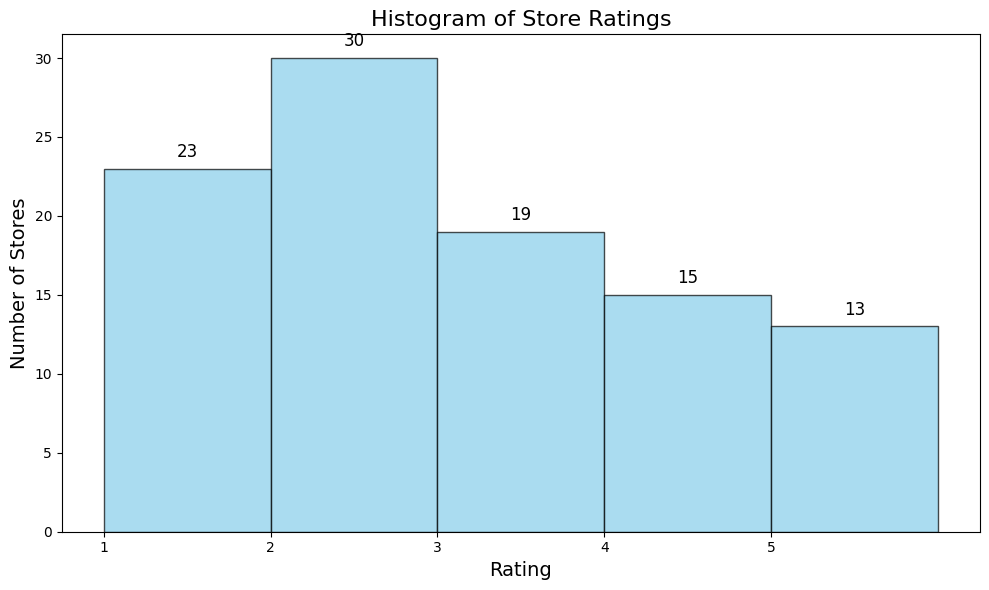

In [10]:
# Define the figure size
plt.figure(figsize=(10, 6))

# Plot the histogram
n, bins, patches = plt.hist(df_stores['Rating'], bins=range(1, 7), edgecolor='black', color='skyblue', alpha=0.7)

# Add title and labels
plt.title('Histogram of Store Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Number of Stores', fontsize=14)

# Set x-axis ticks to be integers
plt.xticks(range(1, 6))

# Add count labels above each bin
for count, bin_edge in zip(n, bins):
    if bin_edge < 6:  # Avoid labeling the last edge
        plt.text(bin_edge + 0.5, count + 0.5, int(count), ha='center', va='bottom', fontsize=12)

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Display the plot
plt.show()

### Which are the schedules of opening and closing of the stores of the app

In [11]:
schedule_data = {
    'Monday_Open': [],
    'Monday_Close': [],
    'Tuesday_Open': [],
    'Tuesday_Close': [],
    'Wednesday_Open': [],
    'Wednesday_Close': [],
    'Thursday_Open': [],
    'Thursday_Close': [],
    'Friday_Open': [],
    'Friday_Close': [],
    'Saturday_Open': [],
    'Saturday_Close': [],
    'Sunday_Open': [],
    'Sunday_Close': []
}

# Populate the dictionary with schedule data
for schedule in df_stores['Schedule']:
    for day in ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']:
        day_cap = day.capitalize()
        times = schedule.get(day, [0, 0])
        if isinstance(times, list) and len(times) == 2:
            schedule_data[f'{day_cap}_Open'].append(times[0])
            schedule_data[f'{day_cap}_Close'].append(times[1])
        else:
            # Handle cases where schedule data is missing or malformed
            schedule_data[f'{day_cap}_Open'].append(0)
            schedule_data[f'{day_cap}_Close'].append(0)

# Convert the dictionary to a DataFrame
df_schedule = pd.DataFrame(schedule_data)

print("Schedule data prepared for box plot.")


Schedule data prepared for box plot.


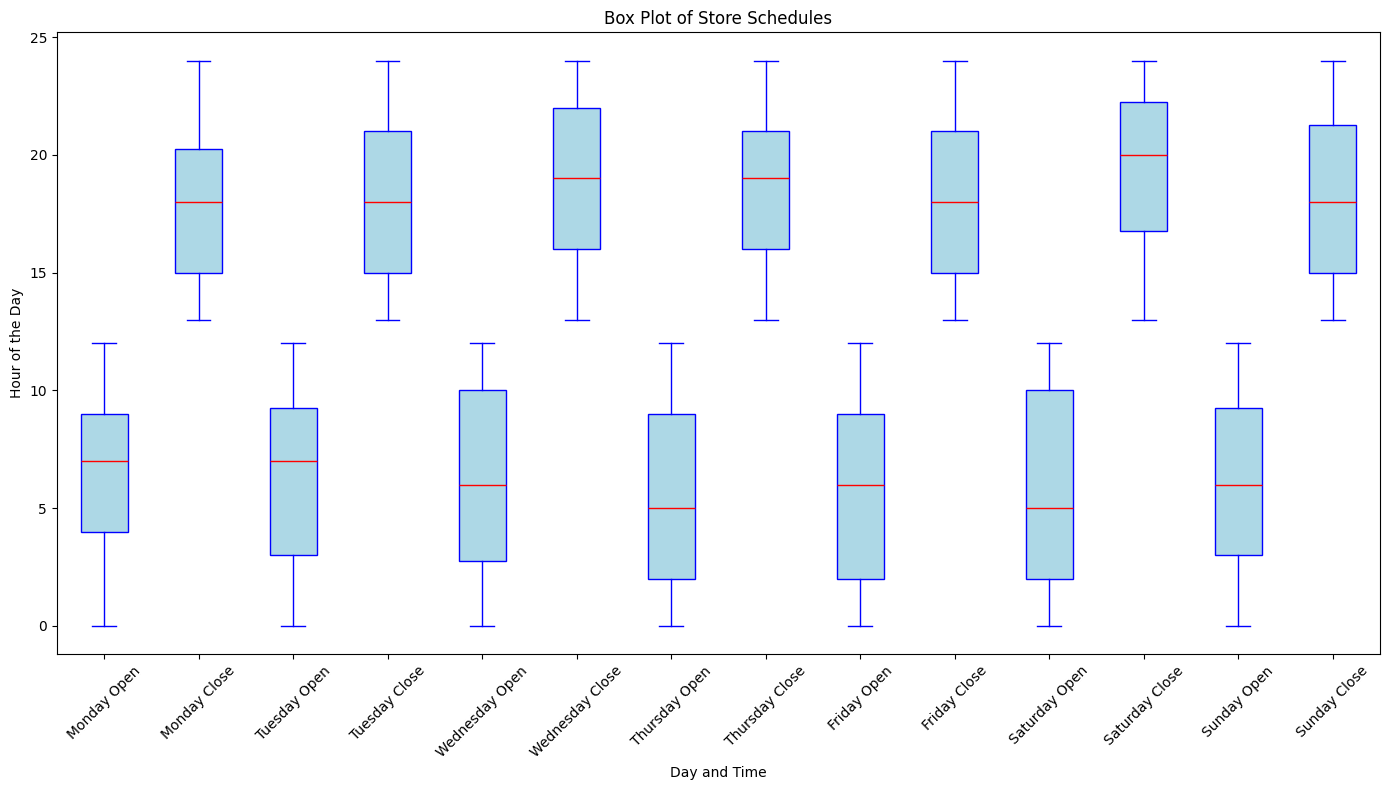

In [12]:
# Set the plot style for better aesthetics

# Define the figure size
plt.figure(figsize=(14, 8))

# Prepare data for box plot
# We'll plot opening and closing times separately for each day
boxplot_data = []
labels = []

for day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']:
    boxplot_data.append(df_schedule[f'{day}_Open'])
    labels.append(f'{day} Open')
    boxplot_data.append(df_schedule[f'{day}_Close'])
    labels.append(f'{day} Close')

plt.boxplot(boxplot_data, labels=labels, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red'),
            whiskerprops=dict(color='blue'),
            capprops=dict(color='blue'),
            flierprops=dict(color='blue', markeredgecolor='blue'))

plt.title('Box Plot of Store Schedules')
plt.xlabel('Day and Time')
plt.ylabel('Hour of the Day')

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()
